## WEB SCRAPING --> CLEANING AND PERFORMING EDA

The goal in this example is to clean and format in a convenient way the data scraped from an online courses website. When scraping, the data obtained is usually in a big mess and unproper format, so we have to clean it.

The goal in this example is to clean and format in a convenient way the data scraped from an online courses website. When scraping, the data obtained is usually in a big mess and unproper format, so we have to clean it.

### IMPORTING LIBRARIES

In [23]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
from lxml import html
pd.set_option('max_colwidth', None)

import warnings
warnings.filterwarnings('ignore')

### DEFINING THE HEADERS AND WEBSITE

The website to scrape in this exercise will be 'www.classcentral.com'. This time, we will scrape the information about online courses in the Machine Learning field. We will use 'request' and 'BeautifulSoup' packages for that, so we have to specify the information related to 'headers' and 'url' before scraping.

In [3]:
#Setting URL and Headers to scrape

url     = 'https://www.classcentral.com/subject/machine-learning'
headers = ({'User-Agent':
            'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36',
            'Accept-Language': 'en-US, en;q=0.5'})

r       = requests.get(url, headers=headers)
soup    = BeautifulSoup(r.text, 'lxml')
tree    = html.fromstring(r.text)

print(r.status_code)

200


### SCRAPING THE INFORMATION

We will capture information of 5 fields in the website:

    -Course name or title
    -Duration
    -Provider
    -Number of reviews
    -Course Rate

We can see in the website to scrape that in our area of interest there are 954 courses that are showed over several pages with 15 courses each one. So, the first thing it is to capture this information for looping over the total number of pages to scrape all the courses information.

In [4]:
#Scraping the total number of courses:
total_courses_str=soup.find('span', attrs={'class':'hidden small-up-inline-block'})
total_courses_str=total_courses_str.text

We need to format the previous information to make it useful for our purposes:

In [5]:
#Capturing only the integer elements of the previous string:

total_courses_num=[int(num) for num in total_courses_str.split() if num.isdigit() ]
total_courses_num

[15, 982]

In [6]:
#Total number of pages for looping:

num_pages=np.ceil(total_courses_num[1]/total_courses_num[0])
num_pages

66.0

So, we have to create a 'for loop' to iterate over 64 pages and collecting the information we are interested in. We will capture information about course names, duration, platform and institution and also reviews and rating of students. We are going to define a custom function to scrape a page and then insert it into a 'for loop' for the several pages we have to scrape.

In [7]:
#Custom function to scrape the information we need

def page_scraping(soup):
    
    #Courses name
    
    course   =[course.text for course in soup.findAll('h2')]
    
    #Platform, duration, cost

    temp =[item.text for item in soup.findAll('ul', attrs={'class': 'margin-top-small'})]
    for i in range(len(temp)):
        temp[i]=temp[i].strip().split('\n\n\n\n\n')
        for item in range(len(temp[i])):
            temp[i][item]=temp[i][item].strip()
    
    platform=[item[0] for item in temp]
    
    duration=[]
    cost=[]
    for item in temp:
        duration.append([x for x in item if ('weeks'in x) | ('hours' in x)])

    for item in temp:
        cost.append([x for x in item if ('Free'in x) | ('Paid' in x) | ('$' in x)])

    
    #Institution of education
    
    institution=[]
    for body in soup.findAll('span', attrs={'class':'row vert-align-middle'}):
    
        if (body.text!='\n\n\n\n\n\n') & (body.text !='\n\n\n\n\n\nMicrocredential\n'):
            institution.append(body.text)
        else:
            institution.append(body.find('img').get('title'))
        
    #Ratings of users/students
    ratings=[]

    for rate in soup.findAll('span', attrs={'class':'cmpt-rating-medium'}):
        ratings.append(rate.get('aria-label'))

    #Number of total reviews
    reviews   =[review.text for review in soup.findAll("span",attrs={"class": "text-3 color-gray margin-left-xxsmall"})]

    return course, platform, duration, cost, institution, ratings, reviews

#### 'FOR LOOP' FOR SCRAPING ALL PAGES

In [8]:
#Scraping all pages: from page 1 to page 64 

href = 'https://www.classcentral.com/subject/machine-learning'
for i in range(1,int(num_pages)+1):
    
    if i==1:
        url=href
    else:
        url=href+'?page='+str(i)

    r    = requests.get(url, headers=headers)
    soup = BeautifulSoup(r.text, 'lxml')
    globals()[f'scraped_{i}'] = page_scraping(soup)

### CHECKING INCONSISTENCIES

After scraping the information from the website and considering that we have used several features or variables to load this information, we have to ensure that all these lists have the same lenght and also that there are not incorrect or null values. Checking these points,  we ensure that there is a correspondence between lists rows and we avoid future errors while joining lists together.

In [9]:
#Joining all the scraped information for testing lenghts and null values.
course=[]
platform=[]
duration=[]
cost=[]
institution=[]
ratings=[]
reviews=[]

for i in range(1,int(num_pages)+1):
    course.append(globals()[f'scraped_{i}'][0])
    platform.append(globals()[f'scraped_{i}'][1])
    duration.append(globals()[f'scraped_{i}'][2])
    cost.append(globals()[f'scraped_{i}'][3])
    institution.append(globals()[f'scraped_{i}'][4])
    ratings.append(globals()[f'scraped_{i}'][5])
    reviews.append(globals()[f'scraped_{i}'][6])

In [10]:
#Checking that all elements have the same size and not missing values for coherence in later unions of the scraped data.

len_course=[]
len_platform=[]
len_duration=[]
len_cost=[]
len_institution=[]
len_ratings=[]
len_reviews=[]

for i in range(0,int(num_pages)):
    len_course.append(len(course[i]))
    len_platform.append(len(platform[i]))
    len_duration.append(len(duration[i]))
    len_cost.append(len(cost[i]))
    len_institution.append(len(institution[i]))
    len_ratings.append(len(ratings[i]))
    len_reviews.append(len(reviews[i]))

    
miss_course=0
miss_platform=0
miss_duration=0
miss_cost=0
miss_institution=0
miss_ratings=0
miss_reviews=0

for i in range(0,int(num_pages)):
    miss_course+=np.abs(len_course[i]-15)
    miss_platform+=np.abs(len_platform[i]-15)
    miss_duration+=np.abs(len_duration[i]-15)
    miss_cost+=np.abs(len_cost[i]-15)
    miss_institution+=np.abs(len_institution[i]-15)
    miss_ratings+=np.abs(len_ratings[i]-15)
    miss_reviews+=np.abs(len_reviews[i]-15)

print('Empty values in Course Name field: {}'.format(miss_course))
print('Empty values in Platform field: {}'.format(miss_platform))
print('Empty values in Duration field: {}'.format(miss_duration))
print('Empty values in Cost field: {}'.format(miss_cost))
print('Empty values in Institution field: {}'.format(miss_institution))
print('Empty values in Ratings field: {}'.format(miss_ratings))
print('Empty values in Num. Reviews field: {}'.format(miss_reviews))

Empty values in Course Name field: 0
Empty values in Platform field: 0
Empty values in Duration field: 0
Empty values in Cost field: 0
Empty values in Institution field: 0
Empty values in Ratings field: 0
Empty values in Num. Reviews field: 882


### DATA FORMATTING

As we can see above, the only variable with null values is Reviews. This means that there are a lot of courses without a rating from users or students. We will replace null values with a zero. To do this, we have to consider in parallel the ratings list, as we don´t know only visualizing the reviews list which courses are the ones without reviews. If we make a comparison between both lists, the items with 'zero stars' in ratings list corresponds to a 'zero reviews' item.

In [11]:
#Replacing empty values in 'Reviews' with zero.

for idj,item in enumerate(ratings):
    for idx, rate in enumerate(item):
        if 'Zero' in rate:
            reviews[idj].insert(idx, '0 reviews')
            

In [12]:
#Replacing empty values in 'Duration' with zero.

temp=[]
for item in duration:
        temp.append([x if x!=[] else '0' for x in item ])
duration=temp

In [13]:
#Removing not necessary information from 'Duration'

duration=[item for sublist in duration for item in sublist]
final_duration=[]
for field in duration:
    for item in field:
        if 'weeks from now' not in item:
                final_duration.append(item)
        else:
            temp_item=[]
            if len(field)==1:
                temp_item.append('0')
            if '0' in temp_item:
                final_duration.append(temp_item)

Once we have checked that all retrieved data has the same lenght and there are not missing values for incoherences during unions; we have to convert to flat lists the above lists, except 'Duration' as we have already transformed it before procceding with data formatting.

In [14]:
#Converting Lists of lists into Flat lists

course_f=[item for sublist in course for item in sublist]
platform_f=[item for sublist in platform for item in sublist]
institution_f=[item for sublist in institution for item in sublist]
cost_f=[item for sublist in cost for item in sublist]
ratings_f=[item for sublist in ratings for item in sublist]
reviews_f=[item for sublist in reviews for item in sublist]

### DEFINING THE DATAFRAME TO SAVE THE DATA

In [162]:
keys=['Course', 'Platform', 'Institution','Duration', 'Cost','Rating', 'Num.Reviews']
values=[course_f,platform_f, institution_f, final_duration, cost_f, ratings_f, reviews_f]
courses_df=pd.DataFrame(dict(zip(keys,values)))
courses_df

,Course,Platform,Institution,Duration,Cost,Rating,Num.Reviews
0,Machine Learning,Coursera,Stanford University,"61 hours worth of material, 11 weeks long",[Free Online Course (Audit)],Five out of five stars,377 reviews
1,Machine Learning for Musicians and Artists,Kadenze,"\n\n\nGoldsmiths, University of London\n\n\n",7 weeks long,[Free Online Course],Five out of five stars,85 reviews
2,Machine Learning Foundations: A Case Study Approach,Coursera,University of Washington,"18 hours worth of material, 6 weeks long",[Free Online Course (Audit)],Four out of five stars,40 reviews
3,Practical Machine Learning,Coursera,Johns Hopkins University,"8-9 hours worth of material, 4 weeks long",[Free Online Course (Audit)],Three and a half out of five stars,27 reviews
4,Machine Learning with Python: from Linear Models to Deep Learning,edX,Massachusetts Institute of Technology,"10-14 hours a week, 15 weeks long",[Free Online Course (Audit)],Three out of five stars,29 reviews
...,...,...,...,...,...,...,...
985,Machine Learning Interpretable: interpretML y LIME,Coursera,Coursera Project Network,0,[Paid Course],Zero out of five stars,0 reviews
986,Aprendizaje automático sin código: Azure ML Designer,Coursera,Coursera Project Network,0,[Paid Course],Zero out of five stars,0 reviews
987,Autoencoders y eventos extremadamente infrecuentes,Coursera,Coursera Project Network,2 hours worth of material,[Paid Course],Zero out of five stars,0 reviews
988,Support Vector Machine Classification in Python,Coursera,Coursera Project Network,"2 hours a week, 1 week long",[Paid Course],Zero out of five stars,0 reviews


### LAST CHANGES BEFORE ANALYSIS

We have to make some more changes before going into analysis. Some columns have lists instead of a single value as values, and there are also some columns with an unappropiate format, let´s take a look to some of them:

In [15]:
courses_df['Institution'][0:15].unique()

array(['Stanford University',
       '\n\n\nGoldsmiths, University of London\n\n\n',
       'University of Washington',
       'Massachusetts Institute of Technology',
       '\n\nUAlberta;\xa0                                    \n              Alberta Machine Intelligence Institute \n',
       'Johns Hopkins University', 'University of California, San Diego ',
       '\n\ndeeplearning.ai;\xa0                                    \n              Stanford \n',
       'Harvard University', 'Universitat Politècnica de València',
       'University of Pennsylvania', 'Google'], dtype=object)

In [163]:
#Formatting 'Institution' feature

import re

courses_df['Institution']=courses_df['Institution'].apply(lambda x: x.replace('\n',' ').strip())
courses_df['Institution']=courses_df['Institution'].apply(lambda x: re.sub(' +', ' ', x))
for r in (('\xa0',' '), (' Microcredential',''), ('; ',';') ):
    courses_df['Institution']=courses_df['Institution'].apply(lambda x: x.replace(*r))

In [164]:
#Formatting 'Duration' feature

courses_df['Mat. Hours']=courses_df['Duration'].apply(lambda x :(x.split(' hours worth')[0] if 'hours worth' in x else '0'))
courses_df['Hours a Week']=courses_df['Duration'].apply(lambda x :(x.split(' hours a week')[0] if 'hours a week' in x else '0'))
courses_df['Weeks Long']=courses_df['Duration'].apply(lambda x :(x.split(' weeks long')[0] if 'weeks long' in x else '0'))
courses_df['Weeks Long']=courses_df['Weeks Long'].apply(lambda x :x.split(',')[1] if (',' in x) else (x if x.isdigit() else '0'))
courses_df=courses_df.drop('Duration', axis=1)

In [165]:
#Formatting 'Cost' feature

courses_df['Cost']=[item for sublist in courses_df['Cost'] for item in sublist]

for r in ((' Online Course (Audit)',''), (' Online Course',''), ('Course',''), ('$',''), (' Available','')):
    courses_df['Cost']=courses_df['Cost'].apply(lambda x: x.replace(*r))

In [166]:
#Formatting 'Ratings' and Reviews' features

courses_df['Num.Reviews']=courses_df['Num.Reviews'].apply(lambda x: x.split('review')[0].strip())
courses_df['Num.Reviews']=courses_df['Num.Reviews'].astype('int')

courses_df['Rating']=courses_df['Rating'].apply(lambda x: x.split('out')[0].strip())
dicty={'Zero':0.0,
        'Zero and a half':0.5,
        'One':1.0,
        'One and a half':1.5, 
        'Two':2.0, 
        'Two and a half':2.5, 
        'Three':3.0, 
        'Three and a half':3.5,  
        'Four':4.0,
        'Four and a half':4.5, 
        'Five':5
       }
courses_df['Rating']=courses_df['Rating'].map(dicty)

In [167]:
courses_df.head()

,Course,Platform,Institution,Cost,Rating,Num.Reviews,Mat. Hours,Hours a Week,Weeks Long
0,Machine Learning,Coursera,Stanford University,Free,5.0,377,61,0,11
1,Machine Learning for Musicians and Artists,Kadenze,"Goldsmiths, University of London",Free,5.0,85,0,0,7
2,Machine Learning Foundations: A Case Study Approach,Coursera,University of Washington,Free,4.0,40,18,0,6
3,Practical Machine Learning,Coursera,Johns Hopkins University,Free,3.5,27,8-9,0,4
4,Machine Learning with Python: from Linear Models to Deep Learning,edX,Massachusetts Institute of Technology,Free,3.0,29,0,10-14,15


### DATA ANALYSIS

Now we have already the data in a convenient format to make some analysis. We will start with a single visualization of the best rated and reviewed courses.

1. Which are the top 15 more reviewed courses? 

It seems that there are a big difference in number of reviews. There is one course that is 'Machine Learning' that seems to have an important quantity of students taking into account the total reviews. There is a big gap between this one and the following one in the list.

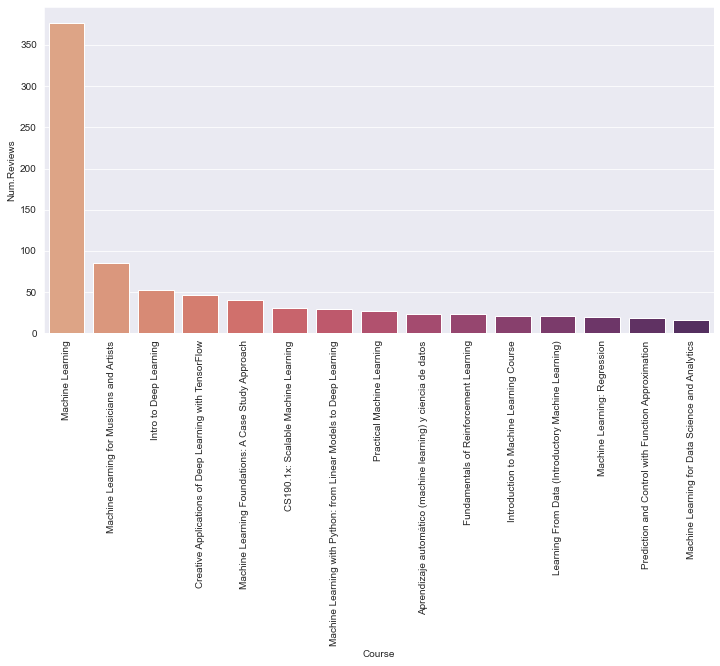

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

plt.figure(figsize=(12,6))
data_sort=courses_df[['Course','Num.Reviews']].sort_values(by='Num.Reviews', ascending=False).head(15)
sns.barplot(x=data_sort['Course'],y=data_sort['Num.Reviews'], palette='flare')
plt.xticks(rotation=90);

2. Which are the top 15 best rated courses?

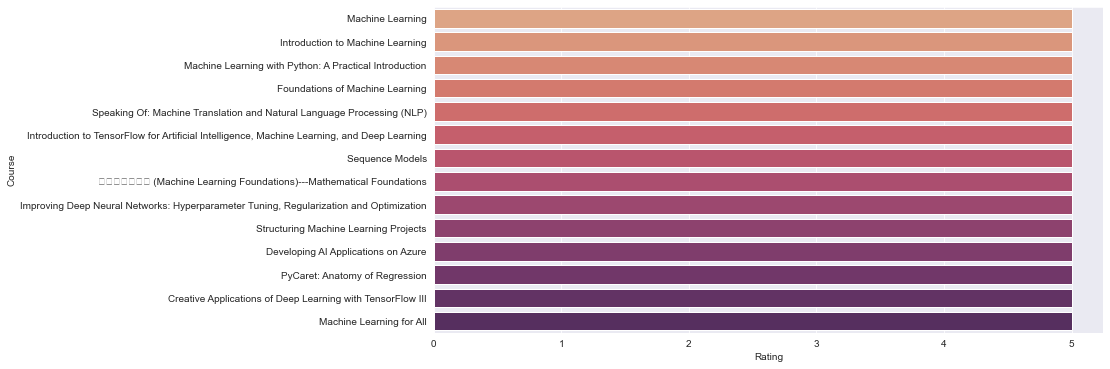

In [24]:
#Plotting the best rated courses

plt.figure(figsize=(12,6))
data_sort=courses_df[['Course','Rating']].sort_values(by='Rating', ascending=False).head(15)
sns.barplot(y=data_sort['Course'],x=data_sort['Rating'], palette='flare');

Well, with the plot below we have the names for the best 15 rated courses. All of them have the best rate with 5 stars, but we know that there are a big difference between courses rates depending on the number of reviews. It is not the same a 5 star rated course based on 300 reviews that the same rate for an only 5 reviewed course. So, we need to explore the number of reviews for the above list of courses.

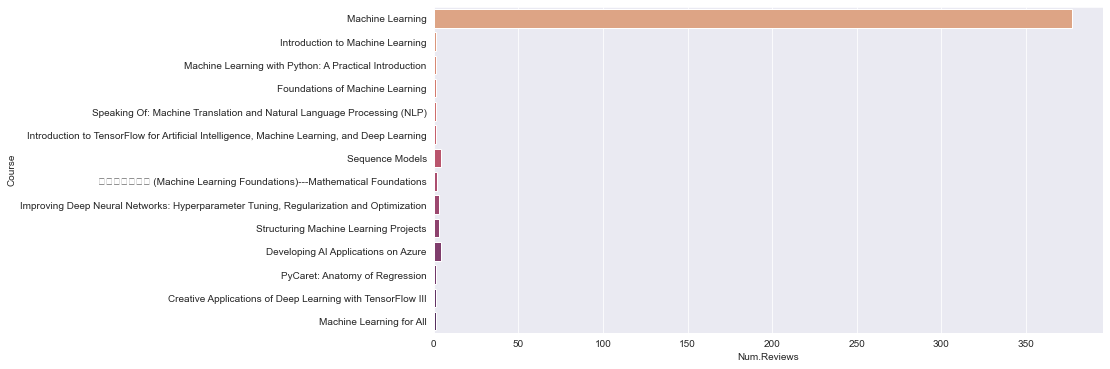

In [25]:
list_=list(data_sort.index)
temp_courses=courses_df.iloc[list_][['Course', 'Num.Reviews']]

plt.figure(figsize=(12,6))
sns.barplot(y=temp_courses['Course'],x=temp_courses['Num.Reviews'], palette='flare');

As we can see, "Machine Learning" Course seems to be the perfect one to start with, as it is rated with 5 stars based on more than 350 reviews of user/students. The rest of best rated courses have very few reviews compared with this one.

3. Which is the mean rate for courses offered by each Online Platform?

There are big differences between each online platform in order to be compared. We see here below that the number of courses offered by each platform is very different; so we can´t compare a 'mean rate' directly without considering this point. To perform a valid comparison, we will consider only platforms with more than 15 courses; and will calculate a 'mean rate' for the best 15 courses of each platform.

In [30]:
#Number of courses offered by each Platform:
courses_df.groupby('Platform')['Course'].count()

Platform
Brilliant                   1
Codecademy                  1
Complexity Explorer         1
Coursera                  459
DataCamp                    3
Edureka                     3
FutureLearn                16
Independent                18
JuliaAcademy                2
Kadenze                     6
LinkedIn Learning          17
MIT OpenCourseWare          2
Microsoft Learn             8
Miríadax                    1
OpenClassrooms              6
Pluralsight               112
Qwiklabs                   17
Skillshare                  2
Stepik                      1
Swayam                     13
The Great Courses Plus      1
Treehouse                   1
Udacity                    20
Udemy                     139
YouTube                    69
edX                        64
freeCodeCamp                5
gacco                       1
openSAP                     1
Name: Course, dtype: int64

In [56]:
#Selecting only platforms with more than 15 courses
mask=courses_df.groupby('Platform')['Course'].count()>=15
more_15=courses_df.groupby('Platform')['Course'].count()[mask]
platforms_15=more_15.index
list(platforms_15.values)

['Coursera',
 'FutureLearn',
 'Independent',
 'LinkedIn Learning',
 'Pluralsight',
 'Qwiklabs',
 'Udacity',
 'Udemy',
 'YouTube',
 'edX']

In [80]:
#Selecting the best 15 courses in each platform above: We have 10 platforms, so 150 courses or rows in dataframe.

mask_platform=courses_df[courses_df['Platform'].apply(lambda x: x in list(platforms_15.values))]
temp=mask_platform.groupby('Platform').apply(lambda x: x[['Course','Rating']].sort_values(by='Rating',ascending=False).head(15))
mean_rate=temp.groupby('Platform').mean().sort_values(by='Rating', ascending=False)
mean_rate

,Rating
Platform,
Coursera,5.000000
edX,4.533333
Udacity,2.866667
Independent,1.500000
Udemy,0.666667
YouTube,0.333333
FutureLearn,0.000000
LinkedIn Learning,0.000000
Pluralsight,0.000000


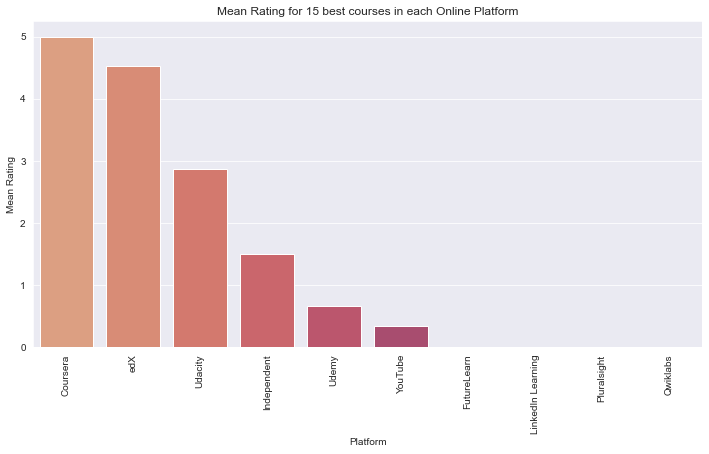

In [81]:
plt.figure(figsize=(12,6))
g=sns.barplot(y=mean_rate['Rating'],x=mean_rate.index, palette='flare')
g.set_title('Mean Rating for 15 best courses in each Online Platform')
g.set_ylabel('Mean Rating')
plt.xticks(rotation=90);

Coursera seems to be the Platform with an offer of 'good' courses, at least, in opinion of actual users, followed by Edx and Udacity. Also, there are several platforms that have a mean rate of zero although they offer also a high quantity of courses. We will take a look to the rates for one of them: 'FutureLearn'.

In [84]:
temp.loc['FutureLearn']

,Course,Rating
263,Apply Creative Machine Learning,0.0
264,Artificial Intelligence and Machine Learning for Business,0.0
265,Introduction to Machine Learning and AI,0.0
328,AWS: Machine Learning Foundations,0.0
471,AI Design and Engineering with Microsoft Azure,0.0
473,Advanced and Applied AI on Microsoft Azure,0.0
475,"Ethics, Laws and Implementing an AI Solution on Microsoft Azure",0.0
480,"Advanced AI on Microsoft Azure: Ethics and Laws, Research Methods and Machine Learning",0.0
481,Microsoft Future Ready: Essential Mathematics for Machine Learning and AI,0.0
482,AI and Machine Learning Algorithms Using Python,0.0


In fact despite of offering a wide range of courses, all of them have zero rate. This no means that all courses are bad, surely no users have rated any course yet for these platforms.

4. What about the price of online courses?

Let´s see the proportion of each course-type offered online relating to price. We can see that in 'Paid' category there are courses with the price specified. As we have many courses without price specified, we will add all the paid courses under the category of 'Paid'.

In [168]:
#Number of courses based on Price
cost_df=courses_df.groupby('Cost')['Course'].count()
cost_df

Cost
1,500.00        1
1,598.00        1
16,000.00       1
2,880.00        1
20,000.00       1
247.00          1
35,000.00       1
350.00          1
398.00          1
49.00           3
50.00          11
574.00          1
584.00          1
597.00          2
599.00          1
7,000.00        1
970.00          1
Free          405
Free Trial    137
Paid          418
Name: Course, dtype: int64

In [169]:
#Calculating the total of paid courses outside the 'Paid' category: There are 30 more paid type courses.

paid_courses=[i for idx, i in enumerate(cost_df) if cost_df.index[idx] not in ['Paid ', 'Free Trial', 'Free']]
extra_paid=np.array(paid_courses).sum()
extra_paid

30

In [181]:
#Mapping these courses to Paid category

courses_df['Cost']=courses_df['Cost'].apply(lambda x: 'Paid' if x =='Paid ' else x)
courses_df['Cost']=courses_df['Cost'].apply(lambda x: 'Paid' if x not in ['Free', 'Free Trial', 'Paid'] else x)

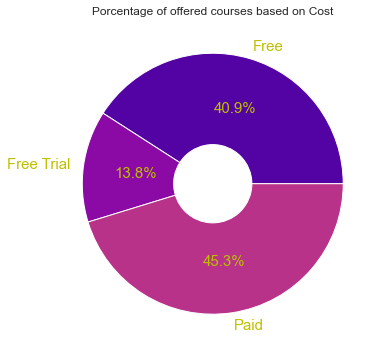

In [207]:
cost_df=courses_df.groupby('Cost')['Course'].count()
fig, ax=plt.subplots(figsize=(10,6))
explode = [0.00,0.00,0.00]
colors = sns.color_palette('plasma')
ax.pie(cost_df, labels=cost_df.index, colors = colors, autopct = '%1.1f%%', startangle=0, 
        explode=explode, textprops={'color':"y", 'fontsize': 15});
#draw circle
centre_circle = plt.Circle((0,0),0.30,color='white', fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Porcentage of offered courses based on Cost');

It seems that there are almost the same proportion for paid and free courses. But near another 14% are also paid courses although they let a free trial period. Now, let go deeper into our previous favorite platforms to see the number of free courses we have in each one.

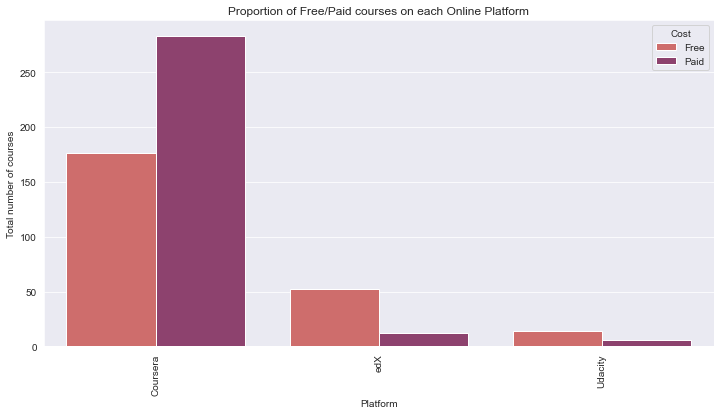

In [215]:
best_platforms=courses_df[courses_df['Platform'].apply(lambda x: x in ['Coursera','edX','Udacity'])]

plt.figure(figsize=(12,6))
g=sns.countplot(data=best_platforms, x='Platform', palette='flare', hue='Cost')
g.set_title('Proportion of Free/Paid courses on each Online Platform')
g.set_ylabel('Total number of courses')
plt.xticks(rotation=90);


Coursera seems to have the bigger offer and also we have seen that it is the best rated one also. Let´s see if it reaches some other expectations. Now we have nearly clear that we will choose a course offered by Coursera, but we can´t dedicate many hours a week, we are too busy. Let´s see what we can choose.

5. What about the hours needed for success the course?

First we need to re-adapt the content in the fields named 'Mat. Hours' for those cases in which the duration of the course is a range. We will assume that the material duration is a mean between both limits. The same case for 'Weeks long' or 'Hours a week'.

In [229]:
#New features based in the mean values for 'duration' variables.

courses_df['Mat. Hours_mean']=courses_df['Mat. Hours'].apply(lambda x: (int(x.split('-')[1])+int(x.split('-')[0]))/2 if '-' in x else int(x) )
courses_df['Hours a Week_mean']=courses_df['Hours a Week'].apply(lambda x: (int(x.split('-')[1])+int(x.split('-')[0]))/2 if '-' in x else int(x) )

In [235]:
courses_df.head()

,Course,Platform,Institution,Cost,Rating,Num.Reviews,Mat. Hours,Hours a Week,Weeks Long,Mat. Hours_mean,Hours a Week_mean
0,Machine Learning,Coursera,Stanford University,Free,5.0,377,61,0,11,61.0,0.0
1,Machine Learning for Musicians and Artists,Kadenze,"Goldsmiths, University of London",Free,5.0,85,0,0,7,0.0,0.0
2,Machine Learning Foundations: A Case Study Approach,Coursera,University of Washington,Free,4.0,40,18,0,6,18.0,0.0
3,Practical Machine Learning,Coursera,Johns Hopkins University,Free,3.5,27,8-9,0,4,8.5,0.0
4,Machine Learning with Python: from Linear Models to Deep Learning,edX,Massachusetts Institute of Technology,Free,3.0,29,0,10-14,15,0.0,12.0


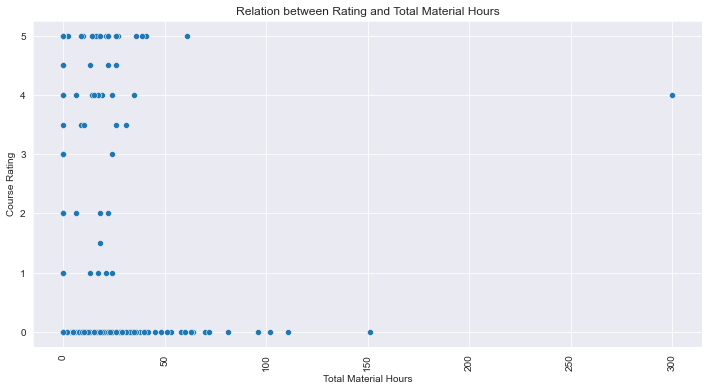

In [241]:
plt.figure(figsize=(12,6))
g=sns.scatterplot(data=courses_df, x='Mat. Hours_mean', y='Rating', palette='flare')
g.set_title('Relation between Rating and Total Material Hours')
g.set_ylabel('Course Rating')
g.set_xlabel('Total Material Hours')
plt.xticks(rotation=90);


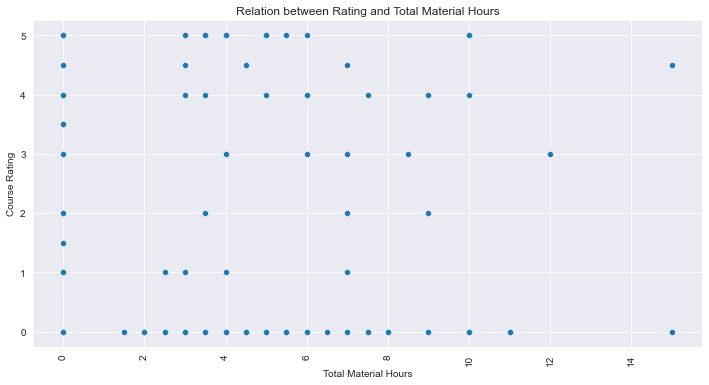

In [239]:
plt.figure(figsize=(12,6))
g=sns.scatterplot(data=courses_df, x='Hours a Week_mean', y='Rating', palette='flare')
g.set_title('Relation between Rating and Total Material Hours')
g.set_ylabel('Course Rating')
g.set_xlabel('Total Material Hours')
plt.xticks(rotation=90);

We see that the majority of courses offer around 50 hours of material but there is not a clear relationship between the rates and the duration of the courses, and also there are many courses with this information missing, so we can´t conclude that the longer the course takes the better.

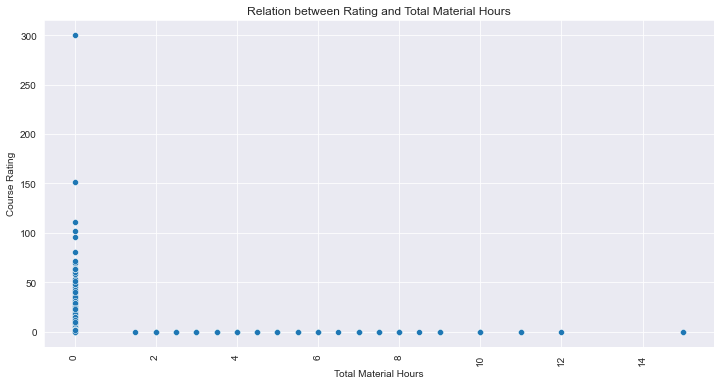

In [243]:
plt.figure(figsize=(12,6))
g=sns.scatterplot(data=courses_df, x='Hours a Week_mean', y='Mat. Hours_mean', palette='flare')
g.set_title('Relation between Rating and Total Material Hours')
g.set_ylabel('Course Rating')
g.set_xlabel('Total Material Hours')
plt.xticks(rotation=90);

In [255]:
#If there is information in 'Hours a Week_mean' there is not in 'Mat. Hours_mean' and viceversa.

courses_df[ (courses_df['Hours a Week_mean']!=0.0)]['Mat. Hours_mean'].mean()
courses_df[ (courses_df['Mat. Hours_mean']!=0.0)]['Hours a Week_mean'].mean()

0.0

In conclusion, it seems that there are not big correlations between the hours of material or duration of the course with the best rates of the students, so we decide to look for a well rated course with a median duration. Obviously, we could continue performing EDA in the dataset to select the course that best fits our interests.